## Naive Bayes

In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.model_selection import GridSearchCV

### Data Prep for ML

In [2]:
train = pd.read_pickle("data/train.pkl").dropna()
test = pd.read_pickle("data/test.pkl").dropna()

In [3]:
train_parent_tdidf_csr = vstack(train["parent_comment_tdidf"])
test_parent_tdidf_csr = vstack(test["parent_comment_tdidf"])

train_tdidf_csr = vstack(train["comment_tdidf"])
test_tdidf_csr = vstack(test["comment_tdidf"])

train_parent_bow_csr = vstack(train["parent_comment_bow"])
test_parent_bow_csr = vstack(test["parent_comment_bow"])

train_bow_csr = vstack(train["comment_bow"])
test_bow_csr = vstack(test["comment_bow"])

In [4]:
train.columns

Index(['comment', 'parent_comment', 'comment_tokens', 'parent_comment_tokens',
       'comment_tokens_bigram', 'parent_comment_tokens_bigram',
       'comment_tokens_trigram', 'parent_comment_tokens_trigram',
       'comment_score', 'parent_comment_score',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive', 'comment_word_count',
       'parent_comment_word_count', 'comment_token_count',
       'parent_comment_token_count', 'comment_unique_word_count',
       'parent_comment_unique_word_count', 'comment_unique_token_count',
       'parent_comment_unique_token_count', 'comment_stopword_count',
       'parent_comment_stopword_count', 'comment_mean_word_length',
       'parent_comment_mean_word_length', 'comment_mean_token_length',
       'parent_comment_mean_token_length', 'comment_char_count',
       'parent_comment_char_count', 'comment_

In [5]:
list_of_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive']

In [6]:
bool_cols = ['weighted_parent_sentiment_score_neutral',
             'weighted_parent_sentiment_score_positive',
             'weighted_comment_sentiment_score_neutral',
             'weighted_comment_sentiment_score_positive']

for col in bool_cols: #need to convert bool type to integer
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)
X_train_gen_features = csr_matrix(train[list_of_features])
y_train_LR = train['label']

X_test_gen_features = csr_matrix(test[list_of_features])
y_test_LR = test['label']

### Baseline 1: General Features

In [7]:
X_train_LR = X_train_gen_features

In [8]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR): 
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5053108414551877
Standard Deviation of roc_auc: 0.00491743706424603


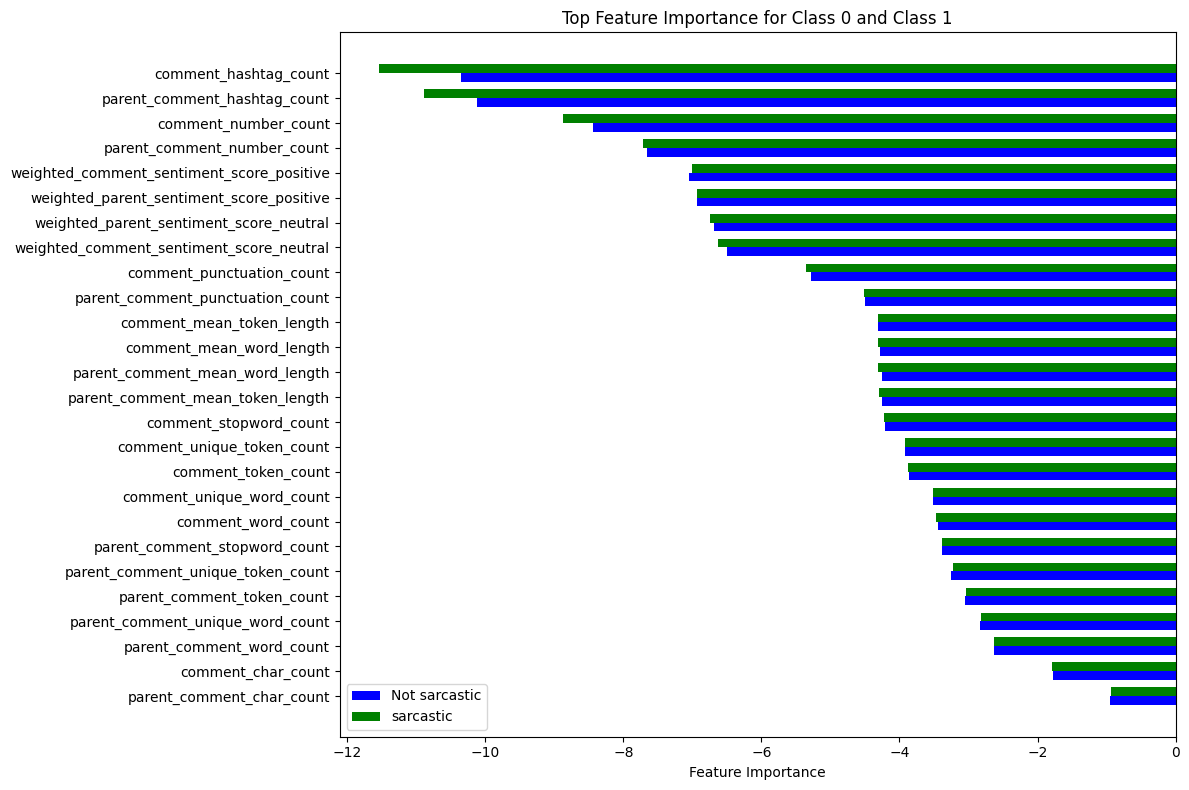

In [9]:
# Plotting feature importance
import matplotlib.pyplot as plt

# Train the model on the entire dataset
model.fit(X_train, y_train)

# Get the feature log probabilities (coefficients) from the model
feature_log_prob = model.feature_log_prob_

# Mapping feature names to importance scores
feature_importance_dict0 = dict(zip(list_of_features, feature_log_prob[0]))
feature_importance_dict1 = dict(zip(list_of_features, feature_log_prob[1]))

# Sort the features by their importance scores for class 0
sorted_features_0 = sorted(feature_importance_dict0.items(), key=lambda x: x[1], reverse=True)
top_features_0 = len(list_of_features)  # Choose how many top features to display for class 0
top_features_names_0 = [feat[0] for feat in sorted_features_0[:top_features_0]]
top_features_scores_0 = [feat[1] for feat in sorted_features_0[:top_features_0]]

# Sort the features by their importance scores for class 1
sorted_features_1 = sorted(feature_importance_dict1.items(), key=lambda x: x[1], reverse=True)
top_features_1 = len(list_of_features)  # Choose how many top features to display for class 1
top_features_names_1 = [feat[0] for feat in sorted_features_1[:top_features_1]]
top_features_scores_1 = [feat[1] for feat in sorted_features_1[:top_features_1]]

# Combine the scores for both classes into one plot
n = top_features_0 
index = np.arange(n)
bar_width = 0.35

plt.figure(figsize=(12, 8))
plt.barh(index, top_features_scores_0, bar_width, label='Not sarcastic', color='blue')
plt.barh(index + bar_width, top_features_scores_1, bar_width, label='sarcastic', color='green')
plt.xlabel('Feature Importance')
plt.title('Top Feature Importance for Class 0 and Class 1')
plt.yticks(index + bar_width / 2, top_features_names_0)
plt.legend()
plt.tight_layout()
plt.show()

### Baseline 2: Comment BoW

In [10]:
X_train_LR = train_bow_csr

In [11]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR): 
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6439986874851111
#unigram: Standard Deviation of roc_auc: 0.0015538454889143783

Mean roc_auc: 0.6539451398593382
Standard Deviation of roc_auc: 0.0018663773341545445


### Baseline 3: Comment TD-IDF

In [12]:
X_train_LR = train_tdidf_csr

In [13]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR): 
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6392604315512
#unigram: Standard Deviation of roc_auc: 0.0014945661295342496

Mean roc_auc: 0.6516729123224697
Standard Deviation of roc_auc: 0.0016794671113447989


### Baseline 4: General Features + BoW

In [14]:
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [15]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR): 
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.6346011511337147
Standard Deviation of roc_auc: 0.009129336279886418


### Baseline 5: General Features + TD-IDF

In [16]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr])

In [17]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR): 
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5856576299149585
Standard Deviation of roc_auc: 0.01455822864352804


### Baseline 6: Gen Features + Comment TDIDF + Parent TDIDF

In [18]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr,train_parent_tdidf_csr])

In [19]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR): 
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5976400104468006
Standard Deviation of roc_auc: 0.014213097801530149


### Baseline 7: Gen + Parent TDIDF

In [20]:
X_train_LR = hstack([X_train_gen_features,train_parent_tdidf_csr])

In [21]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR): 
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5272753565019327
Standard Deviation of roc_auc: 0.006666106199031639


### Hyper Parameter Tuning with Grid Search CV

In [22]:
### Using gen features and bow
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [23]:
param_grid = {
    'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],  # You can extend this list
    'fit_prior': [True, False],
}


In [24]:
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='roc_auc', verbose=4)
grid_search.fit(X_train_LR, y_train_LR)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .........alpha=0.2, fit_prior=True;, score=0.688 total time=   0.0s
[CV 2/5] END .........alpha=0.2, fit_prior=True;, score=0.666 total time=   0.0s
[CV 3/5] END .........alpha=0.2, fit_prior=True;, score=0.681 total time=   0.0s
[CV 4/5] END .........alpha=0.2, fit_prior=True;, score=0.684 total time=   0.0s
[CV 5/5] END .........alpha=0.2, fit_prior=True;, score=0.681 total time=   0.0s
[CV 1/5] END ........alpha=0.2, fit_prior=False;, score=0.688 total time=   0.0s
[CV 2/5] END ........alpha=0.2, fit_prior=False;, score=0.666 total time=   0.0s
[CV 3/5] END ........alpha=0.2, fit_prior=False;, score=0.681 total time=   0.0s
[CV 4/5] END ........alpha=0.2, fit_prior=False;, score=0.684 total time=   0.0s
[CV 5/5] END ........alpha=0.2, fit_prior=False;, score=0.681 total time=   0.0s
[CV 1/5] END .........alpha=0.4, fit_prior=True;, score=0.690 total time=   0.0s
[CV 2/5] END .........alpha=0.4, fit_prior=True;

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc', verbose=4)

In [25]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best score achieved during grid search
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'alpha': 0.6, 'fit_prior': True}
Best Score: 0.6819322827550783


In [26]:
# Best estimator (the fitted model with the best parameters)
best_estimator = grid_search.best_estimator_
print("Best Estimator:", best_estimator)

# Results for all parameter combinations
cv_results = grid_search.cv_results_

Best Estimator: MultinomialNB(alpha=0.6)


In [27]:
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

pd.set_option('display.max_colwidth',None)
results_df = pd.DataFrame({'Params':params,'Mean Score':mean_test_scores,'STD':std_test_scores})
results_df["Params"] = results_df["Params"].apply(lambda x: ', '.join([f'{key}: {value}' for key, value in x.items()]))
results_df.sort_values('STD', inplace=True)
results_df.sort_values('Mean Score', ascending=False,inplace=True)
results_df


#for mean_score, std_score, param in zip(mean_test_scores, std_test_scores, params):
    #print(f"Mean Score: {mean_score:.3f} (±{std_score:.3f}) for params: {param}")

,Params,Mean Score,STD
4,"alpha: 0.6, fit_prior: True",0.681932,0.008536
5,"alpha: 0.6, fit_prior: False",0.681932,0.008536
6,"alpha: 0.8, fit_prior: True",0.681787,0.008815
7,"alpha: 0.8, fit_prior: False",0.681787,0.008815
2,"alpha: 0.4, fit_prior: True",0.681644,0.008160
3,"alpha: 0.4, fit_prior: False",0.681644,0.008160
8,"alpha: 1.0, fit_prior: True",0.681450,0.009036
9,"alpha: 1.0, fit_prior: False",0.681450,0.009036
0,"alpha: 0.2, fit_prior: True",0.680133,0.007558
1,"alpha: 0.2, fit_prior: False",0.680133,0.007558


### Compare to Test Set

In [28]:
X_test_LR = hstack([X_test_gen_features,test_bow_csr])
#X_test_LR = scaler.fit_transform(X_test_LR)

In [29]:
y_pred_test = best_estimator.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.6398838026998598
